In [1]:
import scipy.io
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,ConfusionMatrixDisplay
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
import scipy.signal as signal
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
# load file
mat_data = scipy.io.loadmat('S3_E3_A1.mat')
mat_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'emg', 'acc', 'stimulus', 'force', 'forcecal', 'subject', 'exercise', 'activation', 'repetition', 'restimulus', 'rerepetition'])

In [3]:
print("Keys in the .mat file:",mat_data.keys())
emg_data = mat_data['emg']  # extract EMG 
acc_data = mat_data['acc']  # extract accelerometer
stimulus = mat_data['stimulus'].flatten()  # labels
restimulus = mat_data['restimulus'].flatten()  # possibly corrected labels
exercise = mat_data['exercise'].flatten()  # Exercise type
print(f"EMG Data Shape: {emg_data.shape}")
print(f"Accelerometer Data Shape: {acc_data.shape}")
print(f"Stimulus labels Shape: {stimulus.shape}")
print(f"Restimulus labels Shape: {restimulus.shape}")
print(f"Exercise Data Shape: {exercise.shape}")
print(f"Unique Stimulus labels: {set(stimulus)}")

Keys in the .mat file: dict_keys(['__header__', '__version__', '__globals__', 'emg', 'acc', 'stimulus', 'force', 'forcecal', 'subject', 'exercise', 'activation', 'repetition', 'restimulus', 'rerepetition'])
EMG Data Shape: (876769, 12)
Accelerometer Data Shape: (876769, 36)
Stimulus labels Shape: (876769,)
Restimulus labels Shape: (876771,)
Exercise Data Shape: (1,)
Unique Stimulus labels: {0, 41, 42, 43, 44, 45, 46, 47, 48, 49}


In [4]:
# low-pass Butterworth filter (1 Hz cutoff)
def butter_lowpass_filter(data,cutoff=1,fs=200,order=1):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b,a = signal.butter(order,normal_cutoff,btype='low',analog=False)
    return signal.filtfilt(b,a,data,axis=0)

In [5]:
# notch filter to remove powerline noise (50Hz)
def notch_filter(data,freq=50,fs=200,harmonics=3):
    for i in range(1,harmonics + 1):
        f0 = i * freq
        Q = 30
        w0 = f0 / fs
        if 0 < w0 < 1:
            b,a = signal.iirnotch(w0,Q)
            data = signal.filtfilt(b,a,data,axis=0)
    return data

In [6]:
# filtering
filtered_emg = butter_lowpass_filter(emg_data,cutoff=1,fs=200)
filtered_emg = notch_filter(filtered_emg,freq=50,fs=200)
# Min-Max Normalization
scaler = MinMaxScaler()
normalized_emg = scaler.fit_transform(filtered_emg)

In [7]:
def plot_spectrum(data,fs,title):
    freqs,psd = signal.welch(data,fs,nperseg=1024)
    plt.figure(figsize=(10,5))
    plt.semilogy(freqs,psd)
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density')
    plt.grid()
    plt.show()

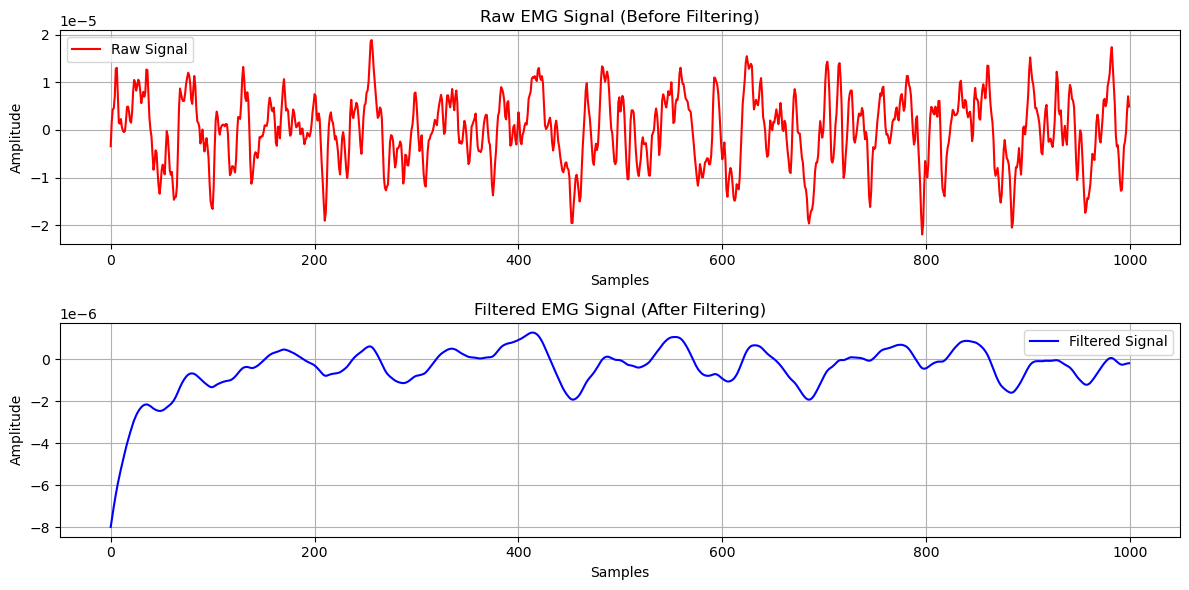

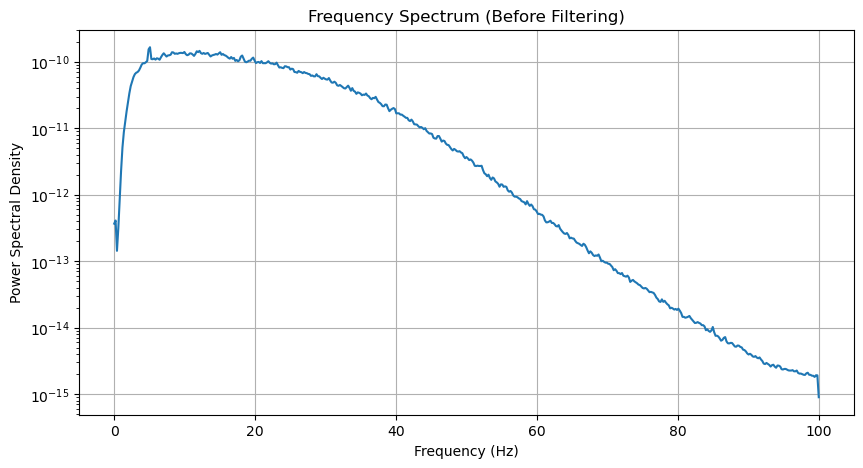

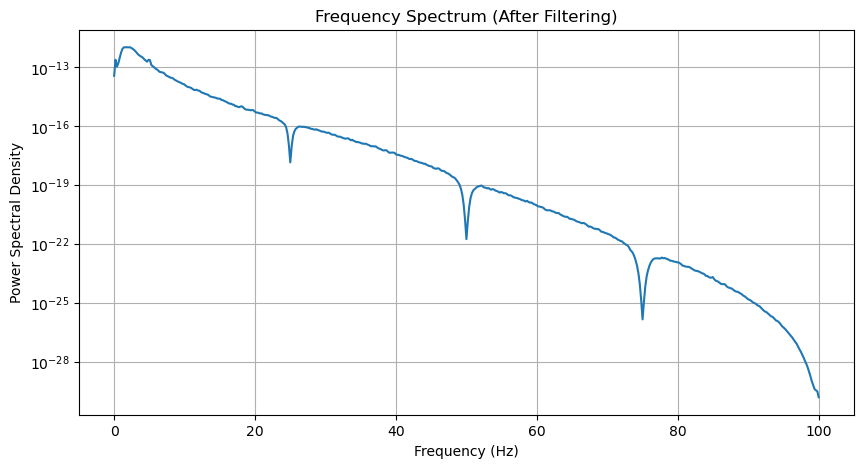

In [8]:
channel_idx = 0 
raw_signal = emg_data[:,channel_idx]
# filtering
filtered_signal = butter_lowpass_filter(raw_signal,cutoff=1,fs=200)
filtered_signal = notch_filter(filtered_signal,freq=50,fs=200)

plt.figure(figsize=(12,6))

# Raw Signal
plt.subplot(2,1,1)
plt.plot(raw_signal[:1000],label="Raw Signal",color='red')
plt.title("Raw EMG Signal (Before Filtering)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
# Filtered Signal
plt.subplot(2,1,2)
plt.plot(filtered_signal[:1000],label="Filtered Signal",color='blue')
plt.title("Filtered EMG Signal (After Filtering)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Plot Frequency Spectrum Before & After Filtering
plot_spectrum(raw_signal,200,"Frequency Spectrum (Before Filtering)")
plot_spectrum(filtered_signal,200,"Frequency Spectrum (After Filtering)")



In [9]:
# Define segmentation parameters
sampling_rate = 200  # Hz
window_size = int(0.2 * sampling_rate)  # 200ms = 40 samples
step_size = int(0.01 * sampling_rate)  # 10ms = 2 samples overlap

# Function to segment EMG and labels
def segment_signal(data,labels,window_size,step_size):
    windows,window_labels = [],[]
    for start in range(0,len(data) - window_size + 1,step_size):
        window = data[start : start + window_size]
        label = labels[start + window_size // 2]  # Assign label from middle of window
        if label != 0:  # Ignore "rest" windows
            windows.append(window)
            window_labels.append(label)
    return np.array(windows),np.array(window_labels)

# Segment data
segmented_emg,segmented_labels = segment_signal(normalized_emg,restimulus,window_size,step_size)

print("Segmented EMG Shape:",segmented_emg.shape)
print("Segmented Labels Shape:",segmented_labels.shape) 


Segmented EMG Shape: (222855, 40, 12)
Segmented Labels Shape: (222855,)


In [10]:
def extract_features(window):
    features = {
        "MAV": np.mean(np.abs(window)),
        "STD": np.std(window),
        "VAR": np.var(window),
        "WL": np.sum(np.abs(np.diff(window))),
        "ZC": np.sum(np.diff(np.sign(window)) != 0),
        "RMS": np.sqrt(np.mean(window ** 2)),
        "SSC": np.sum(np.diff(np.sign(np.diff(window))) != 0),
    }
    return features

# Extract features for each window
feature_list = []
for i, window in enumerate(segmented_emg):
    features = extract_features(window)
    features["Label"] = segmented_labels[i]
    feature_list.append(features)

features_df = pd.DataFrame(feature_list)
print(features_df.shape)


(222855, 8)


In [11]:
# evaluate model performance
def evaluate_model(y_true,y_pred,model_name):
    print(f"\nResults for {model_name}:")
    print("Confusion Matrix:")
    # Confusion Matrix
    cm = confusion_matrix(y_true,y_pred,labels=y.unique())
    plt.figure(figsize=(8,6))
    sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=y.unique(),yticklabels=y.unique())
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    # classification report
    print("\nClassification Report:")
    print(classification_report(y_true,y_pred))
    # accuracy
    accuracy = accuracy_score(y_true,y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    return accuracy


Results for Random Forest:
Confusion Matrix:


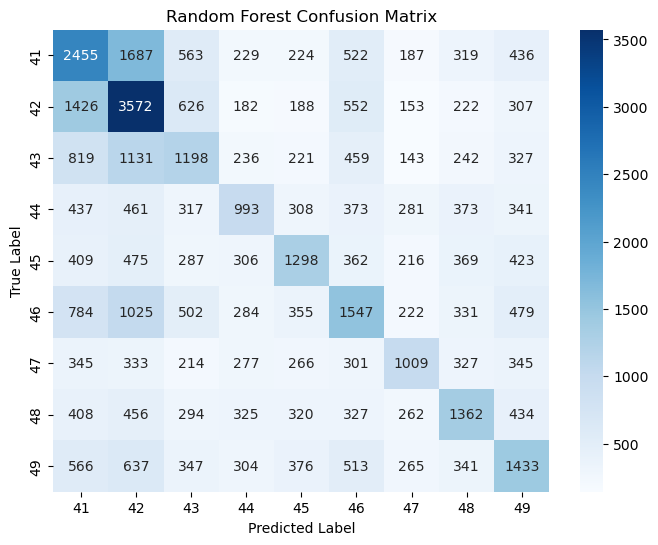


Classification Report:
              precision    recall  f1-score   support

          41       0.32      0.37      0.34      6622
          42       0.37      0.49      0.42      7228
          43       0.28      0.25      0.26      4776
          44       0.32      0.26      0.28      3884
          45       0.37      0.31      0.34      4145
          46       0.31      0.28      0.30      5529
          47       0.37      0.30      0.33      3417
          48       0.35      0.33      0.34      4188
          49       0.32      0.30      0.31      4782

    accuracy                           0.33     44571
   macro avg       0.33      0.32      0.32     44571
weighted avg       0.33      0.33      0.33     44571

Accuracy: 0.33
Random Forest Accuracy: 0.33


In [12]:
# Separate features and labels
X = features_df.drop(columns=['Label'])
y = features_df['Label']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)
rf_model = RandomForestClassifier(n_estimators=100,random_state=42)  # Random Forest with 100 trees
rf_model.fit(X_train,y_train)
y_pred_rf = rf_model.predict(X_test)
rf_accuracy = evaluate_model(y_test,y_pred_rf,"Random Forest")
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")


Results for KNN:
Confusion Matrix:


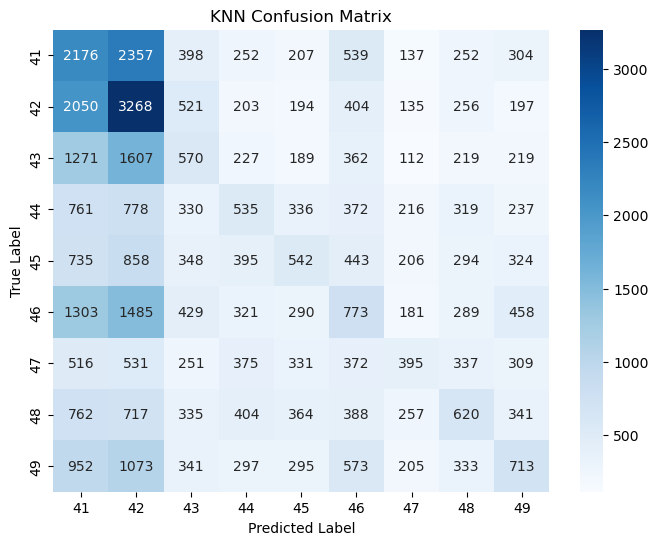


Classification Report:
              precision    recall  f1-score   support

          41       0.21      0.33      0.25      6622
          42       0.26      0.45      0.33      7228
          43       0.16      0.12      0.14      4776
          44       0.18      0.14      0.16      3884
          45       0.20      0.13      0.16      4145
          46       0.18      0.14      0.16      5529
          47       0.21      0.12      0.15      3417
          48       0.21      0.15      0.17      4188
          49       0.23      0.15      0.18      4782

    accuracy                           0.22     44571
   macro avg       0.20      0.19      0.19     44571
weighted avg       0.21      0.22      0.20     44571

Accuracy: 0.22

KNN Accuracy: 0.22


In [13]:
knn_model = KNeighborsClassifier(n_neighbors=20,n_jobs=-1)
knn_model.fit(X_train,y_train)
y_pred_svm = knn_model.predict(X_test)
knn_model = evaluate_model(y_test,y_pred_svm,"KNN")
print(f"\nKNN Accuracy: {knn_model:.2f}")